In [1]:
cd "C:\Users\gupta\OneDrive\Documents\BANA\Spring25\ML Design"

C:\Users\gupta\OneDrive\Documents\BANA\Spring25\ML Design


In [2]:
import pandas as pd

# Load game metadata and user ratings
metadata_df = pd.read_csv(r'C:\Users\gupta\OneDrive\Documents\BANA\Spring25\ML Design\games_metadata_5k.csv')
ratings_df = pd.read_csv(r'C:\Users\gupta\OneDrive\Documents\BANA\Spring25\ML Design\game_ratings.csv')

print("Data successfully ingested!")

Data successfully ingested!


In [3]:
print("\n Checking for missing values:")
print("Metadata missing values:\n", metadata_df.isnull().sum())
print("Ratings missing values:\n", ratings_df.isnull().sum())

print("\n Checking if 'game_id' is numeric:")
metadata_game_id_numeric = metadata_df['game_id'].apply(lambda x: str(x).isdigit()).all()
ratings_game_id_numeric = ratings_df['game_id'].apply(lambda x: str(x).isdigit()).all()
print("Metadata game_id numeric:", metadata_game_id_numeric)
print("Ratings game_id numeric:", ratings_game_id_numeric)

print("\n Checking for out-of-range user ratings (should be between 1 and 5):")
invalid_ratings = ratings_df[~ratings_df['rating'].between(1, 5)]
print("Invalid rating entries found:", len(invalid_ratings))

print("\n Checking for duplicate records:")
print("Duplicate rows in metadata:", metadata_df.duplicated().sum())
print("Duplicate rows in ratings:", ratings_df.duplicated().sum())

print("\n Checking if 'released' column is in valid date format:")
metadata_df['released'] = pd.to_datetime(metadata_df['released'], errors='coerce')
invalid_release_count = metadata_df['released'].isnull().sum()
print(f"Invalid or missing release dates: {invalid_release_count}")

print("\n Checking for missing genres/platforms:")
print("Missing genres:", metadata_df['genres'].isnull().sum())
print("Missing platforms:", metadata_df['platforms'].isnull().sum())


 Checking for missing values:
Metadata missing values:
 game_id            0
name               0
description       30
genres            24
platforms          1
rating             0
released          36
cover_image        4
game_link          0
metacritic_url    30
dtype: int64
Ratings missing values:
 game_id    0
user_id    0
rating     0
dtype: int64

 Checking if 'game_id' is numeric:
Metadata game_id numeric: True
Ratings game_id numeric: True

 Checking for out-of-range user ratings (should be between 1 and 5):
Invalid rating entries found: 0

 Checking for duplicate records:
Duplicate rows in metadata: 0
Duplicate rows in ratings: 0

 Checking if 'released' column is in valid date format:
Invalid or missing release dates: 36

 Checking for missing genres/platforms:
Missing genres: 24
Missing platforms: 1


In [4]:
# 1. Replace empty strings with NaN
metadata_df.replace('', pd.NA, inplace=True)

# 2. Convert 'released' to datetime
metadata_df['released'] = pd.to_datetime(metadata_df['released'], errors='coerce')

# 3. Ensure 'game_id' is numeric (drop rows where it's not)
metadata_df = metadata_df[pd.to_numeric(metadata_df['game_id'], errors='coerce').notnull()]
metadata_df['game_id'] = metadata_df['game_id'].astype(int)

# 4. Drop rows with missing critical fields
critical_fields = ['released', 'genres', 'platforms', 'description', 'metacritic_url']
cleaned_metadata = metadata_df.dropna(subset=critical_fields)
cleaned_metadata.reset_index(drop=True, inplace=True)
print("Cleaned metadata shape:", cleaned_metadata.shape)


Cleaned metadata shape: (4912, 10)


In [5]:
# 5. Filter valid ratings (between 1 and 5)
valid_ratings = ratings_df[ratings_df['rating'].between(1, 5)]

# 6. Average user rating per game
average_ratings = valid_ratings.groupby('game_id')['rating'].mean().reset_index()
average_ratings.rename(columns={'rating': 'user_avg_rating'}, inplace=True)

# 7. Merge with cleaned metadata
final_merged_df = pd.merge(cleaned_metadata, average_ratings, on='game_id', how='left')

# 8. Save final merged dataset
final_merged_df.to_csv('cleaned_metadata.csv', index=False)
print("✅ Final processed data saved to 'cleaned_metadata.csv'")


print("final_merged_df shape:", final_merged_df.shape)

✅ Final processed data saved to 'cleaned_metadata.csv'
final_merged_df shape: (4912, 11)


In [6]:
final_merged_df.info()
final_merged_df.isnull().sum()
final_merged_df['game_id'].sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4912 entries, 0 to 4911
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   game_id          4912 non-null   int32         
 1   name             4912 non-null   object        
 2   description      4912 non-null   object        
 3   genres           4912 non-null   object        
 4   platforms        4912 non-null   object        
 5   rating           4912 non-null   float64       
 6   released         4912 non-null   datetime64[ns]
 7   cover_image      4911 non-null   object        
 8   game_link        4912 non-null   object        
 9   metacritic_url   4912 non-null   object        
 10  user_avg_rating  4912 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(1), object(7)
memory usage: 403.1+ KB


3549    555994
2934      4903
1068      3437
2738     21563
3383     14843
623      27938
3772     25142
384       9575
3827      2476
1843     19412
Name: game_id, dtype: int32

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import time

# Load the dataset
data = final_merged_df

# Feature engineering
data['release_year'] = pd.to_datetime(data['released']).dt.year
data['description_length'] = data['description'].str.len()

# Select features
features = ['user_avg_rating', 'release_year', 'genres', 'platforms', 'description_length']
X = data[features]
y = data['rating']

# Handle categorical and numerical features
numerical_features = ['user_avg_rating', 'release_year', 'description_length']
categorical_features = ['genres', 'platforms']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Define models
rf_modelv1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

xgb_modelv1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate and print results
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")
    
    # Feature importance
    feature_names = numerical_features + model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    importances = model.named_steps['regressor'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print(f"\nTop 5 Feature Importances for {model_name}:")
    print(feature_importance_df.head(5))
    
    return r2, mse, train_time

# Evaluate Random Forest
rf_r2, rf_mse, rf_time = evaluate_model(rf_modelv1, "Random Forest", X_train, X_test, y_train, y_test)

# Evaluate XGBoost
xgb_r2, xgb_mse, xgb_time = evaluate_model(xgb_modelv1, "XGBoost", X_train, X_test, y_train, y_test)

# Compare models
print("\nModel Comparison:")
print(f"Random Forest R²: {rf_r2:.4f}, MSE: {rf_mse:.4f}, Training Time: {rf_time:.2f}s")
print(f"XGBoost R²: {xgb_r2:.4f}, MSE: {xgb_mse:.4f}, Training Time: {xgb_time:.2f}s")
if rf_r2 > xgb_r2:
    print("Random Forest performs better based on R² score.")
else:
    print("XGBoost performs better based on R² score.")


Random Forest Results:
R² Score: 0.2552
Mean Squared Error: 0.4404
Training Time: 8.81 seconds

Top 5 Feature Importances for Random Forest:
                  Feature  Importance
1            release_year    0.169115
2      description_length    0.120770
905          platforms_PC    0.107420
0         user_avg_rating    0.102261
2036  platforms_macOS, PC    0.011775

XGBoost Results:
R² Score: 0.3020
Mean Squared Error: 0.4127
Training Time: 0.11 seconds

Top 5 Feature Importances for XGBoost:
                               Feature  Importance
905                       platforms_PC    0.105823
2036               platforms_macOS, PC    0.022865
2041        platforms_macOS, PC, Linux    0.021606
473   genres_Simulation, Casual, Indie    0.019468
1                         release_year    0.014645

Model Comparison:
Random Forest R²: 0.2552, MSE: 0.4404, Training Time: 8.81s
XGBoost R²: 0.3020, MSE: 0.4127, Training Time: 0.11s
XGBoost performs better based on R² score.


In [11]:
# Hyper-parameter Tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 6]
}

grid_search = GridSearchCV(xgb_modelv1, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best XGBoost R² Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
y_pred = grid_search.predict(X_test)
print(f"Test R² Score: {r2_score(y_test, y_pred):.4f}")

Best XGBoost R² Score: 0.3028
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Test R² Score: 0.2899


In [13]:
# changing the max_depth=3 and n_estimator=200 as per GridSearch results
xgb_modelv1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])
xgb_modelv2 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
])

# Evaluate XGBoost v1
xgb_r2, xgb_mse, xgb_time = evaluate_model(xgb_modelv1, "XGBoost", X_train, X_test, y_train, y_test)

# Evaluate XGBoost v2
xgb_r2v2, xgb_msev2, xgb_timev2 = evaluate_model(xgb_modelv2, "XGBoost", X_train, X_test, y_train, y_test)

# Compare models
print("\nModel Comparison:")
print(f"XGBoost R² v1: {xgb_r2:.4f}, MSE: {xgb_mse:.4f}, Training Time: {xgb_time:.2f}s")
print(f"XGBoost R² v2: {xgb_r2v2:.4f}, MSE: {xgb_msev2:.4f}, Training Time: {xgb_timev2:.2f}s")
if xgb_r2 > xgb_r2v2:
    print("XGBoost v1 performs better based on R² score.")
else:
    print("XGBoost v2 performs better based on R² score.")



XGBoost Results:
R² Score: 0.3020
Mean Squared Error: 0.4127
Training Time: 0.14 seconds

Top 5 Feature Importances for XGBoost:
                               Feature  Importance
905                       platforms_PC    0.105823
2036               platforms_macOS, PC    0.022865
2041        platforms_macOS, PC, Linux    0.021606
473   genres_Simulation, Casual, Indie    0.019468
1                         release_year    0.014645

XGBoost Results:
R² Score: 0.2899
Mean Squared Error: 0.4198
Training Time: 0.10 seconds

Top 5 Feature Importances for XGBoost:
                                                Feature  Importance
905                                        platforms_PC    0.114307
2036                                platforms_macOS, PC    0.030602
86    genres_Action, Adventure, RPG, Strategy, Simul...    0.030020
1                                          release_year    0.028133
2041                         platforms_macOS, PC, Linux    0.026233

Model Comparison:
XGBoost

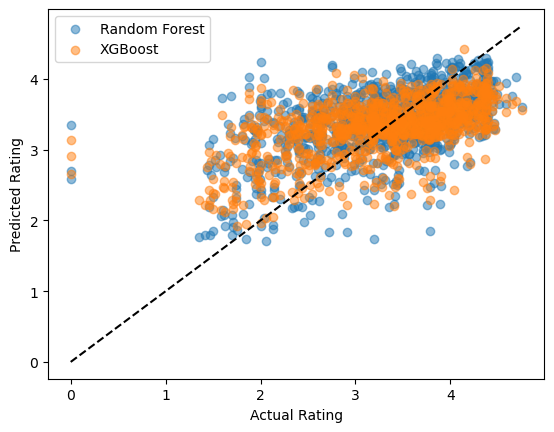

In [15]:
import matplotlib.pyplot as plt

plt.scatter(y_test, rf_modelv1.predict(X_test), label='Random Forest', alpha=0.5)
plt.scatter(y_test, xgb_modelv1.predict(X_test), label='XGBoost', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.show()